## Data Wrangling Project- WeRateDogs Twitter Data

In this project we will be gathering data from 3 different sources then access them and clean them. Our source of data are:
- The WeRateDogs Twitter archive: I Downloaded the file twitter_archive_enhanced.csv manually from the Udacity classroom.
- The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and is downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
- Each tweet's retweet count and favorite ("like") count at minimum, and any additional data that might be interesting. Using the tweet IDs in the WeRateDogs Twitter archive, we query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.


In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import requests
import os
import re
import seaborn as sns
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline

### Data Gathering Process 

Step 1: Data Gathered from the WeRateDogs twitter archive

In [2]:
# load WeRateDogs twitter archive data 
twitter_archive= pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Step 2: Image predictions Data gathered by programmatically using the Requests library and URL

In [20]:
# Download a file programmatically using request library and given url
# reference :https://www.codementor.io/@aviaryan/downloading-files-from-urls-in-python-77q3bs0un

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url, allow_redirects=True)
open('image-predictions.tsv', 'wb').write(r.content)

335079

In [3]:
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


Step 3: Gather data using twitter API 

In [36]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# load personal info into variables consumer_key, consumer_secret, access_token, access_secret
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [37]:
#setup tweepy and build auth handler
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [38]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# Reference: Udacity resource twitter_api.py
fails_dict = {}

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
       
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass

print(fails_dict)

Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Fail
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Fail
Success
Success
Success
Success
Success
Fail
Success
Success
Fail
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Fail
Success
Success
Success
Success
Success
Success
Success
Success

In [42]:
#create a list to later convert to dataframe
tweet_data=[]
with open('tweet_json.txt', encoding= 'utf-8') as json_file:
    line = json_file.readline()
    for line in json_file:
        data = json.loads(line)
        tweet_id = data["id"]
        retweet_counts = data["retweet_count"] 
        favorite_counts = data["favorite_count"]
        
        #append to list
        tweet_data.append({'tweet_id':tweet_id ,'retweet_count':retweet_counts ,
                           'favorite_count':favorite_counts })

In [43]:
#create dataframe
tweet_info = pd.DataFrame(tweet_data, columns=['tweet_id', 'retweet_count', 'favorite_count'])

#save the master dataframe to the file 'new_tweet_json.txt' 
# I have created new file here, you can omit the next two steps or proceed to update and load the existing tweet_json file

tweet_info.to_csv('new_tweet_json.txt', index=False)


In [4]:
#Now load the saved file into dataframe 
tweet_information = pd.read_csv('new_tweet_json.txt')
tweet_information.head(5)

,tweet_id,retweet_count,favorite_count
0,892177421306343426,5688,31142
1,891815181378084864,3770,23454
2,891689557279858688,7855,39389
3,891327558926688256,8460,37619
4,891087950875897856,2838,18951


### Access Gathered Data

#### Visual Assessment

I have initially conducted a visual assessment by using pandas. 

In [5]:
#display full text
pd.options.display.max_colwidth = 200  # reference: https://stackoverflow.com/questions/29902714/print-very-long-string-completely-in-pandas-dataframe
#visual assessment for twitter_archive
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [6]:
#visual assessment for image_predictions
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [7]:
#visual assessment for tweet_information
tweet_information

,tweet_id,retweet_count,favorite_count
0,892177421306343426,5688,31142
1,891815181378084864,3770,23454
2,891689557279858688,7855,39389
3,891327558926688256,8460,37619
4,891087950875897856,2838,18951
5,890971913173991426,1845,11027
6,890729181411237888,17154,60820
7,890609185150312448,3906,26068
8,890240255349198849,6671,29820
9,890006608113172480,6658,28696


#### Programmatic Assessment

While visual assessment helps to become familiar with the dataset, programmatic assessment will help us identify the quality and tidiness issues. 

In [8]:
#get information about dataset twitter_archive
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
#get information about dataset image_predictions
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [10]:
#get information about dataset tweet_information
tweet_information.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
tweet_id          2330 non-null int64
retweet_count     2330 non-null int64
favorite_count    2330 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [11]:
#examine statistics of dataset twitter_archive
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
#examine statistics of dataset image_predictions
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [13]:
#examine statistics of dataset tweet_information
tweet_information.describe()

,tweet_id,retweet_count,favorite_count
count,2.330000e+03,2330.000000,2330.000000
mean,7.418433e+17,2695.860944,7527.133906
std,6.817501e+16,4560.867166,11690.781467
min,6.660209e+17,1.000000,0.000000
25%,6.782612e+17,546.000000,1314.500000
50%,7.182408e+17,1265.500000,3277.000000
75%,7.986600e+17,3128.750000,9227.250000
max,8.921774e+17,77591.000000,155722.000000


In [14]:
#check for duplicate tweets
twitter_archive[twitter_archive['tweet_id'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [15]:
#chexk for duplicate tweets
image_predictions[image_predictions['tweet_id'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [16]:
#check for duplicate tweets
tweet_information[tweet_information['tweet_id'].duplicated()]

,tweet_id,retweet_count,favorite_count


In [17]:
#check for null values in twitter_archive
sum(twitter_archive.tweet_id.isnull())

0

In [18]:
#check for null values in image_predictions
sum(image_predictions.tweet_id.isnull())

0

In [19]:
#check for null values in tweet_information
sum(tweet_information.tweet_id.isnull())

0

In [20]:
#check for outliers 
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [21]:
#list outliers with rating above 30
# while checking for outliers we know that there are no negative values
twitter_archive.query('rating_numerator> 30')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None


In [22]:
#no of outliers
twitter_archive.query('rating_numerator> 30').shape[0]

21

In [23]:
#check for denominator values other than 10
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [24]:
twitter_archive.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,http...",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,http...",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitte

In [25]:
twitter_archive.query('rating_denominator != 10').shape[0]

23

In [26]:
twitter_archive.query('rating_denominator ==0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [27]:
#check the text for the actual rating since rating_denominator=0 is not valid
twitter_archive.query('tweet_id==835246439529840640')['text']

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object

In [28]:
#check the text if there are any decimal values for rating_numerators
twitter_archive[twitter_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id', 'text', 'rating_numerator']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,text,rating_numerator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [29]:
#check the name columns to identify if there is incorrect data
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
Sadie          8
the            8
Daisy          7
an             7
Buddy          7
Bailey         7
Toby           7
Dave           6
Oscar          6
Leo            6
Bella          6
Jax            6
Scout          6
Stanley        6
Koda           6
Milo           6
Rusty          6
Jack           6
Larry          5
            ... 
Bode           1
Maks           1
Goose          1
Pilot          1
Georgie        1
Arya           1
Zooey          1
Gòrdón         1
Kulet          1
Roscoe         1
Shikha         1
Antony         1
Eleanor        1
Jo             1
Saydee         1
Orion          1
Duddles        1
Chuck          1
Snoopy         1
Clarkus        1
Pubert         1
Bronte         1
Kathmandu      1
Ole            1
Peanut         1
Corey          1
Horace         1
Reptar        

In [30]:
#check for the different types of sources 
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [31]:
# range of values for retweet_count
tweet_information.retweet_count.sort_values()

278         1
1270        2
261         2
327         2
108         3
28          4
1055        6
53          7
62         10
410        10
2313       11
2272       14
177        15
171        17
1498       18
2293       18
202        19
2163       21
1212       25
392        25
179        25
592        26
942        27
2198       29
862        31
2301       32
2234       32
2311       32
2233       33
331        34
        ...  
1716    18569
431     19204
430     19204
914     20925
295     20925
1052    21127
511     21297
433     21297
635     21521
1600    21521
147     21797
638     22657
605     24151
110     24496
288     27457
442     27457
161     28590
157     29282
847     29282
1804    30325
1740    31250
128     32866
519     35378
432     37324
429     37324
64      40515
396     43694
516     56559
1054    57565
1014    77591
Name: retweet_count, Length: 2330, dtype: int64

In [32]:
#range of values for favorite count
tweet_information.favorite_count.sort_values()

912          0
581          0
884          0
582          0
421          0
202          0
583          0
584          0
212          0
1217         0
418          0
417          0
585          0
220          0
195          0
221          0
586          0
587          0
408          0
239          0
593          0
405          0
871          0
862          0
596          0
403          0
599          0
398          0
504          0
414          0
         ...  
638      45916
54       46275
52       47374
847      49747
1088     49796
129      49812
605      50488
442      52309
349      53348
378      57224
6        60820
117      61930
21       64296
341      67103
40       67899
147      70968
36       72093
75       74302
1804     74660
519      76007
1740     78136
110      78395
161      86274
432      87890
64       98987
1054    115065
128     116172
516     120280
396     132708
1014    155722
Name: favorite_count, Length: 2330, dtype: int64

In [33]:
#check for null values in image urls 
sum(image_predictions.jpg_url.isnull())

0

In [34]:
#list columns across all datasets
all_columns= pd.Series(list(twitter_archive)+list(image_predictions)+list(tweet_information))
all_columns

0                       tweet_id
1          in_reply_to_status_id
2            in_reply_to_user_id
3                      timestamp
4                         source
5                           text
6            retweeted_status_id
7       retweeted_status_user_id
8     retweeted_status_timestamp
9                  expanded_urls
10              rating_numerator
11            rating_denominator
12                          name
13                         doggo
14                       floofer
15                        pupper
16                         puppo
17                      tweet_id
18                       jpg_url
19                       img_num
20                            p1
21                       p1_conf
22                        p1_dog
23                            p2
24                       p2_conf
25                        p2_dog
26                            p3
27                       p3_conf
28                        p3_dog
29                      tweet_id
30        

In [35]:
#check for columns duplicated across datasets
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

> On visual assessment and sample assessment I have come across the issue of more than one breed type in each row. To assess this further I have checked for different combination and found all the tweet_ids with more than one dog breed. Next I will check the text for each id to identify the issue as the dog breeds have been extracted from the text

In [36]:
#check if there are more than one dog_stages in each row
#checking for combination doggo+floofer ,doggo+pupper and doggo+puppo
twitter_archive.query('doggo == "doggo" and floofer == "floofer" | doggo == "doggo" and puppo =="puppo" | doggo == "doggo" and pupper == "pupper"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None
822,770093767776997377

In [37]:
#check if there are more than one dog_stages in each row
#checking for combination floofer+pupper and floofer+puppo
twitter_archive.query('floofer== "floofer" and pupper == "pupper" | floofer== "floofer" and puppo == "puppo"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [38]:
#check if there are more than one dog_stages in each row
#checking for combination pupper+puppo
twitter_archive.query('puppo== "puppo" and pupper == "pupper"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [39]:
#check if there are more than one dog_stages in each row
#checking for combination doggo+pupper+puppo, doggo+floofer+pupper , 
#puppo+doggo+floofer , floofer+pupper+puppo
twitter_archive.query('doggo == "doggo" and floofer == "floofer" and pupper =="pupper" | doggo == "doggo" and puppo =="puppo" and pupper =="pupper" | floofer == "floofer" and pupper =="pupper" and puppo =="puppo" | doggo == "doggo" and floofer == "floofer" and puppo == "puppo"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [40]:
#check if there are more than one dog_stages in each row
#checking for combination doggo+pupper+puppo+floofer
twitter_archive.query('doggo == "doggo" and floofer == "floofer" and puppo == "puppo" and pupper =="pupper" ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Quality  (We need to clean only 8 Quality and 2 Tidiness Issues)

  - twitter_archive
        - There are extra columns which are not needed 
           - Incorrect dog names such as quiet, a, an, such , None, his. There are 745 rows with name having value None. We can also see that the incorrect names start with lowercase
        - Denominator have values other than 10
        - Some tweets have value for retweet_status_id and retweet_status_user_id which indicates that they are retweets.
        - 181 retweets - we will not be analysing retweets as we only want original data
        - tweet_id datatype is int instead of string
        - timestamp datatype is string instead of datetime
        - Source has html tags. Four sources of data identified as Twitter for iPhone, Vine - Make a Scene,Twitter Web Client, TweetDeck
        - doggo, floofer, pupper, puppo have values None instead of Nan
        - There are missing values for dog stages
        - More than single value of dog stage in a single tweet for 14 tweet_ids
        - 21 outliers with value above 30 for rating_numerators
        - There are 23 values where the rating_denominator is not equal to 10 of which one with tweet_id==835246439529840640 has a value 0.  
        - Rating_numerator has decimal values which have been incorrectly recorded 
   
    
  - image_predictions
        - Column names are not descriptive
        - In some rows the #1 prediction for image is not a breed of dog. In some rows all the predictions are not breeds of dogs.
        - Some original tweets do not have images.(which is a pre requisite for the project)
        -tweet_id datatype is int instead of string
    
  - tweet_information
        - tweet_id datatype is int instead of string
        - We have 2330 non-duplicated tweet ids.

#### Tidiness Issues

- Separate columns for dog stages
- Merge the datasets image_predictions and tweet_information with twitter_archive. 
- Column tweet_id is duplicated across datasets
- The image_predictions dataset has 3 columns each for dog_breed prediction, confidence level and if breed predicted is a dog or not
- Merge three columns for dog breed and image prediction probability into one

### Cleaning Data

In [41]:
#make copy of each dataframe
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_information_clean = tweet_information.copy()

#### 1. Define

> The datatype of tweet_id is int and we will change it to string

#### Code

In [42]:
# change the datatype of 'tweet_id' to string in all three datasets
twitter_archive_clean['tweet_id']=twitter_archive_clean.tweet_id.astype(str)
image_predictions_clean['tweet_id']=image_predictions_clean.tweet_id.astype(str)
tweet_information_clean['tweet_id']=tweet_information_clean.tweet_id.astype(str)

#### Test

In [43]:
#check the data type for tweet_id
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

In [44]:
#check the data type for tweet_id
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [45]:
#check the data type for tweet_id
tweet_information_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
tweet_id          2330 non-null object
retweet_count     2330 non-null int64
favorite_count    2330 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


#### 2. Define

We need to change the datatype of column 'timestamp' from string to datetime

#### Code

In [46]:
# change the datatype of column 'timestamp' to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#### Test

In [47]:
#check the datatype
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

#### 3. Define
> We will remove columns in the twitter_archive_clean dataset which are not required

#### Code

In [48]:
# remove columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_timestamp
twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_timestamp'], axis = 1)

#### Test

In [49]:
#check if the extra columns are removed
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

#### 4. Define
> While assessing the dataset we have come across rows which have more than one dog stage in a single row. 
> We will use the tweet_ids identified to get the text and then change the value of the dog stage individually.
> This will be done by visually assessing the text and the image url in the text to identify the correct dog stage

>> We need to merge the four columns of dog stages (doggo, floofer, pupper, puppo) to single column of dog stage.

#### Code

> Firstly we will identify the correct dog stages for rows with multiple dog stages

In [50]:
# using tweet ids we identified during assessment we will generate the complete text to find the correct dog_stage
twitter_archive_clean.query('tweet_id == ["855851453814013952","854010172552949760" , "817777686764523521", "808106460588765185", "802265048156610565", "801115127852503040", "785639753186217984", "781308096455073793", "775898661951791106", "770093767776997377", "759793422261743616", "751583847268179968", "741067306818797568", "733109485275860992"]').text.sort_values()

200     At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
531                         Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
191           Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
565                                                                                                    Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
1113                                                                                              Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda
889                         Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at 

In [51]:
#after manual examination of text I will programatically change the values 
#df.loc[i,"C"]="newValue"
#https://stackoverflow.com/questions/31569384/set-value-for-particular-cell-in-pandas-dataframe-with-iloc
twitter_archive_clean.loc[191, "doggo"]="None" #doggo agenda but definitely a puppo
twitter_archive_clean.loc[200, "floofer"]="None" #definitely not a floofer owl  
twitter_archive_clean.loc[460, "doggo"]="None" #didodoggo is IG handle, not a doggo
twitter_archive_clean.loc[531, "doggo"]="doggopupper"#two dogs of the same breed but different dog_stages
twitter_archive_clean.loc[531, "pupper"]="None"
twitter_archive_clean.loc[565, "doggo"]="doggopupper" #two dogs of the same breed but different dog_stages
twitter_archive_clean.loc[565, "pupper"]="None"
twitter_archive_clean.loc[575, "doggo"]="None" #pupper haunted by a doggo
twitter_archive_clean.loc[705, "doggo"]="None" # not a doggo or pupper, probably a hedgehog
twitter_archive_clean.loc[705, "pupper"]="None"
twitter_archive_clean.loc[733, "doggo"]="doggopupper"
twitter_archive_clean.loc[733, "pupper"]="None"
# id=778 is a retweet
# id=822 is a retweet
twitter_archive_clean.loc[889, "doggo"]="doggopupper" #two dogs of the same breed but different dog_stages
twitter_archive_clean.loc[889, "pupper"]="None"
twitter_archive_clean.loc[956, "pupper"]="None"
twitter_archive_clean.loc[1063, "doggo"]="doggopupper" #two dogs of the same breed but different dog_stages
twitter_archive_clean.loc[1063, "pupper"]="None"
twitter_archive_clean.loc[1113, "doggo"]="doggopupper" #two dogs of the same breed but different dog_stages
twitter_archive_clean.loc[1113, "pupper"]="None"
# note that the rating for both dogs is same in all cases with 2 dogs

#### Test

In [52]:
# test if the dog_stages have been changed
twitter_archive_clean.query('index == [191, 200, 460, 531, 565, 575, 705, 733, 889, 956, 1063, 1113]')

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,2017-04-22 18:31:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,None,None,None,puppo
200,854010172552949760,2017-04-17 16:34:26,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,None,None,None
460,817777686764523521,2017-01-07 16:59:28,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,None,None,pupper,None
531,808106460588765185,2016-12-12 00:29:28,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggopupper,None,None,None
565,802265048156610565,2016-11-25 21:37:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggopupper,None,None,None
575,801115127852503040,2016-11-22 17:28:25,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,None,None,pupper,None
705,785639753186217984,2016-10-11 00:34:48,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,None,None,None,None
733,781308096455073793,2016-09-29 01:42:20,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggopupper,None,None,None
889,759793422261743616,2016-07-31 16:50:42,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,doggopupper,None,None,None
956,751583847268179968,2016-07-09 01:08:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho ht

#### Code

In [53]:
#remove extra columns and melt into a single column
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars=['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'expanded_urls', 'rating_numerator','rating_denominator', 'name'],
                           value_vars =['doggo', 'floofer', 'pupper', 'puppo'], var_name='stages', value_name='dog_stage')

In [54]:
#drop the stages column
twitter_archive_clean = twitter_archive_clean.drop(['stages'], axis = 1)

#### Test

In [55]:
#list the columns
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage']

In [56]:
twitter_archive_clean.dog_stage.value_counts()

None           9043
pupper          249
doggo            87
puppo            30
floofer           9
doggopupper       6
Name: dog_stage, dtype: int64

#### Code

In [57]:
# remove dog_stage duplicated rows 
twitter_archive_clean = twitter_archive_clean.sort_values('dog_stage', ascending=False) #reference: https://jamesrledoux.com/code/drop_duplicates
twitter_archive_clean = twitter_archive_clean.drop_duplicates(subset='tweet_id', keep='first')

#### Test

In [58]:
#check the value_count for different dog stages
twitter_archive_clean.dog_stage.value_counts()

None           1977
pupper          249
doggo            85
puppo            30
floofer           9
doggopupper       6
Name: dog_stage, dtype: int64

In [59]:
#check that the number of rows is same as original dataframe
twitter_archive_clean.dog_stage.count()

2356

In [60]:
#confirm that there are no duplicated rows
sum(twitter_archive_clean.tweet_id.duplicated())

0

#### 5. Define
> Replace the string 'None' with Nan in the dog_stage column
> We will not be removing the rows with missing data or "None"/Nan value. This is just to identify rows with missing data

#### Code

In [61]:
#replace "None" with Nan in dog_stage column to easily identify missing data
twitter_archive_clean['dog_stage'].replace("None", np.nan, inplace=True) #https://stackoverflow.com/questions/23743460/replace-none-with-nan-in-pandas-dataframe

#### Test

In [62]:
#check info
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 7781 to 7119
Data columns (total 11 columns):
tweet_id                    2356 non-null object
timestamp                   2356 non-null datetime64[ns]
source                      2356 non-null object
text                        2356 non-null object
retweeted_status_id         181 non-null float64
retweeted_status_user_id    181 non-null float64
expanded_urls               2297 non-null object
rating_numerator            2356 non-null int64
rating_denominator          2356 non-null int64
name                        2356 non-null object
dog_stage                   379 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 220.9+ KB


In [63]:
twitter_archive_clean.dog_stage.value_counts()

pupper         249
doggo           85
puppo           30
floofer          9
doggopupper      6
Name: dog_stage, dtype: int64

#### 6. Define
> We will remove rows with retweets

#### Code

In [64]:
# filter rows based on non-null values of column retweeted_status_id
df = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.notnull()] #https://cmdlinetips.com/2018/03/how-to-filter-a-pandas-dataframe-based-on-null-values-of-a-column/
twitter_archive_clean = twitter_archive_clean.drop(df.index) #https://cmdlinetips.com/2019/10/how-to-drop-rows-based-on-a-column-value-in-pandas-dataframe/

#### Test

In [65]:
#check if the retweets are removed
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 7781 to 7119
Data columns (total 11 columns):
tweet_id                    2175 non-null object
timestamp                   2175 non-null datetime64[ns]
source                      2175 non-null object
text                        2175 non-null object
retweeted_status_id         0 non-null float64
retweeted_status_user_id    0 non-null float64
expanded_urls               2117 non-null object
rating_numerator            2175 non-null int64
rating_denominator          2175 non-null int64
name                        2175 non-null object
dog_stage                   343 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 203.9+ KB


#### 7. Define
> Remove columns retweeted_status_id, retweeted_status_user_id from dataset twitter_archive_clean as we have removed retweets data and we don't need these columns any more

#### Code

In [66]:
# remove columns retweeted_status_id, retweeted_status_user_id
twitter_archive_clean = twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id'], axis = 1)

#### Test

In [67]:
#check if the columns are removed
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage']

#### 8. Define
- Create a single dog breed column based on the highest confidence level and if the prediction is a breed of dog.
- Once we create single column for image prediction confidence level and dog breed each, we will remove extra columns which are not required.
- Dog breed values are both upper and lower case so we will change all of the values to lowercase to maintain consistency

#### Code
>create single columns for image prediction confidence level and dog breed each

In [68]:
#create new lists for dog breed and image prediction confidence level
dog_breed=[]
img_prediction_conf=[]
# iterate over rows with iterrows()
# reference: https://cmdlinetips.com/2018/12/how-to-loop-through-pandas-rows-or-how-to-iterate-over-pandas-rows/
for index, row in image_predictions_clean.iterrows():
    if row.p1_dog== True:
        dog_breed.append(row.p1)
        img_prediction_conf.append(row.p1_conf)
    elif row.p2_dog == True:
        dog_breed.append(row.p2)
        img_prediction_conf.append(row.p2_conf)
    elif row.p3_dog == True:
        dog_breed.append(row.p3)
        img_prediction_conf.append(row.p3_conf)
    else:
        dog_breed.append(np.nan)
        img_prediction_conf.append(np.nan)
#create a new column for dog breed 
#se=pd.Series(dog_breed)
#image_predictions_clean['dog_breed']=se.values
image_predictions_clean['dog_breed']=dog_breed
image_predictions_clean['img_prediction_conf']=img_prediction_conf

#### Test

In [69]:
image_predictions_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed,img_prediction_conf
500,675845657354215424,https://pbs.twimg.com/media/CWEWClfW4AAnqhG.jpg,1,pug,0.883952,True,Boston_bull,0.011057,True,French_bulldog,9.839810e-03,True,pug,0.883952
28,666407126856765440,https://pbs.twimg.com/media/CT-NvwmW4AAugGZ.jpg,1,black-and-tan_coonhound,0.529139,True,bloodhound,0.244220,True,flat-coated_retriever,1.738100e-01,True,black-and-tan_coonhound,0.529139
1906,852311364735569921,https://pbs.twimg.com/media/C9QEqZ7XYAIR7fS.jpg,1,barbell,0.971581,False,dumbbell,0.028418,False,go-kart,5.595040e-07,False,NaN,NaN
645,681610798867845120,https://pbs.twimg.com/media/CXWRZBgWkAEHMea.jpg,1,toy_poodle,0.821704,True,miniature_poodle,0.116042,True,Yorkshire_terrier,1.484720e-02,True,toy_poodle,0.821704
364,672884426393653248,https://pbs.twimg.com/media/CVaQ0M4UsAAki3t.jpg,1,tusker,0.122410,False,warthog,0.119870,False,water_buffalo,1.058560e-01,False,NaN,NaN
389,673359818736984064,https://pbs.twimg.com/media/CVhBLohWEAAXtYl.jpg,1,English_setter,0.696568,True,Brittany_spaniel,0.104046,True,Ibizan_hound,3.483250e-02,True,English_setter,0.696568
1031,711363825979756544,https://pbs.twimg.com/media/Cd9Fn5QUMAAYMT4.jpg,1,Pembroke,0.750906,True,Cardigan,0.241152,True,basenji,2.639620e-03,True,Pembroke,0.750906
922,702217446468493312,https://pbs.twimg.com/media/Cb7HCMkWEAAV9zY.jpg,1,golden_retriever,0.242419,True,chow,0.226800,True,cocker_spaniel,1.940860e-01,True,golden_retriever,0.242419
179,669324657376567296,https://pbs.twimg.com/media/CUnrN7vUcAAfGvN.jpg,1,seashore,0.201659,False,Cardigan,0.131544,True,sandbar,1.014300e-01,False,Cardigan,0.131544
921,701981390485725185,https://pbs.twimg.com/media/Cb3wWWbWEAAy06k.jpg,1,Pomeranian,0.491022,True,weasel,0.130879,False,Yorkshire_terrier,9.924100e-02,True,Pomeranian,0.491022


#### Code
- Remove extra columns in the dataset image_predictions_clean
- Change all the values in dog breed column to lowercase

In [70]:
# remove columns p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
image_predictions_clean=image_predictions_clean.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis = 1)

In [71]:
#change values in column dog breed to lowercase 
image_predictions_clean['dog_breed']=image_predictions_clean['dog_breed'].str.lower()

#### Test

In [72]:
#check for the new list of columns in dataset image_predictions_clean
list(image_predictions_clean)

['tweet_id', 'jpg_url', 'img_num', 'dog_breed', 'img_prediction_conf']

In [73]:
#check for uppercase values in column dog_breed
image_predictions_clean.dog_breed.str.isupper().any()

False

#### 9. Define
- merge dataset image_predictions_clean and twitter_archive_clean
- merge the above created dataset with tweet_information_clean dataset

#### Code

In [74]:
#merge image_predictions_clean and twitter_archive_clean using inner join
twitter_merge_1 = pd.merge(twitter_archive_clean, image_predictions_clean, on='tweet_id', how='inner')
#merge the above dataset to tweet_information_clean dataset
twitter_data = pd.merge(twitter_merge_1, tweet_information_clean, on='tweet_id', how='inner')

In [75]:
#create a copy of the final dataset generated by merging the 3 datasets
twitter_data_clean = twitter_data.copy()

#### Test
- Test if the datasets have merged correctly
- verify that there are no tweets beyond 1st August 2017
- verify that all the tweets have images

In [76]:
#check if all the columns required have been merged correctly
list(twitter_data_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'jpg_url',
 'img_num',
 'dog_breed',
 'img_prediction_conf',
 'retweet_count',
 'favorite_count']

In [77]:
twitter_data_clean.shape

(1986, 15)

In [78]:
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 15 columns):
tweet_id               1986 non-null object
timestamp              1986 non-null datetime64[ns]
source                 1986 non-null object
text                   1986 non-null object
expanded_urls          1986 non-null object
rating_numerator       1986 non-null int64
rating_denominator     1986 non-null int64
name                   1986 non-null object
dog_stage              304 non-null object
jpg_url                1986 non-null object
img_num                1986 non-null int64
dog_breed              1679 non-null object
img_prediction_conf    1679 non-null float64
retweet_count          1986 non-null int64
favorite_count         1986 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(8)
memory usage: 248.2+ KB


In [79]:
#check for tweets beyond August 1st 2017
twitter_data_clean.query('timestamp >="2017-08-02"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count


In [80]:
#check if all tweets have images
sum(twitter_data_clean.jpg_url.isnull())

0

#### 10. Define
> Create a new column for rating numerator by extracting the ratings from the text

> Create a new column for rating denominator with datatype float. Check for denominators not having a value 10. In our assessment we have seen that some of these denominators have been incorrectly extracted from the text. We will change these values individually to get a more accurate dataset

> Create a column rating_standardized which will hold values for rating_numerator_new/rating_denominator_new and give us standardized ratings which will make analysis easier

> drop columns rating_numerator and rating_denominator as they are not required and have incorrect data

#### Code
> Create a new column for rating numerator by extracting the ratings from the text

In [81]:
#reference: https://knowledge.udacity.com/questions/33009
correct_rating = twitter_data_clean.text.str.extract('((?:\d+\.)?\d+)\/', expand=True).astype(float)
twitter_data_clean['rating_numerator_new'] = correct_rating
#correct_rating

#### Test

In [82]:
#check for the tweet_ids we found during cleaning process
twitter_data_clean.query("tweet_id ==['883482846933004288', '832215909146226688', '786709082849828864', '778027034220126208', '681340665377193984', '680494726643068929']")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new
128,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,pupper,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,1638,6618,11.27
324,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,NaN,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,kuvasz,0.438627,481,1703,11.26
1850,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,NaN,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,pomeranian,0.467321,6225,18535,9.75
1979,883482846933004288,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,NaN,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,golden_retriever,0.943082,8992,42863,13.50


#### Code
> Create a new column for rating denominator with datatype float. Check for denominators not having a value 10. In our assessment we have seen that some of these denominators have been incorrectly extracted from the text. We will change these values individually to get a more accurate dataset

In [83]:
#create a new column rating_denominator_new which will store the denominator values as float
twitter_data_clean['rating_denominator_new']=twitter_data_clean.rating_denominator.astype(float)


In [84]:
# Most denominators are of value 10.0, so we will check that values != 10 are valid ratings or incorrect data
twitter_data_clean.query('rating_denominator_new != 10.0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new
342,682962037429899265,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7,11,Darrel,NaN,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,1,chihuahua,0.155207,16450,36583,7.0,11.0
344,684225744407494656,2016-01-05 04:11:44,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3","https://twitter.com/dog_rates/status/684225744407494656/photo/1,https://twitter.com/dog_rates/status/684225744407494656/photo/1",143,130,None,NaN,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,2,golden_retriever,0.203249,207,1218,143.0,130.0
361,684222868335505415,2016-01-05 04:00:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,https://twitter.com/dog_rates/status/684222868335505415/photo/1,121,110,None,NaN,https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg,1,soft-coated_wheaten_terrier,0.791182,1360,3792,121.0,110.0
461,704054845121142784,2016-02-28 21:25:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60,50,a,NaN,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg,1,great_pyrenees,0.667939,907,2902,60.0,50.0
573,697463031882764288,2016-02-10 16:51:59,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44,40,None,NaN,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,labrador_retriever,0.999885,1391,3394,44.0,40.0
821,666287406224695296,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,an,NaN,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,1,maltese_dog,0.857531,61,136,1.0,2.0
938,675853064436391936,2015-12-13 01:41:41,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,"https://twitter.com/dog_rates/status/675853064436391936/photo/1,https://twitter.com/dog_rates/status/675853064436391936/photo/1",88,80,None,NaN,https://pbs.twimg.com/media/CWEcxqWVEAAHyGH.jpg,1,labrador_retriever,0.868367,1258,2624,88.0,80.0
991,677716515794329600,2015-12-18 05:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,https://twitter.com/dog_rates/status/677716515794329600/photo/1,144,120,None,NaN,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,1,chow,0.025438,966,3005,144.0,120.0
1189,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://tw

In [85]:
#df.loc[i,"C"]="newValue"
#change the values of the incorrect numerators and denominators individually
twitter_data_clean.loc[342, "rating_numerator_new"]= 10.0
twitter_data_clean.loc[342, "rating_denominator_new"]=10.0
twitter_data_clean.loc[821, "rating_numerator_new"]=9.0
twitter_data_clean.loc[821, "rating_denominator_new"]=10.0
twitter_data_clean.loc[1321, "rating_numerator_new"]=np.nan
twitter_data_clean.loc[1321, "rating_denominator_new"]=np.nan
twitter_data_clean.loc[1531, "rating_numerator_new"]=14.0
twitter_data_clean.loc[1531, "rating_denominator_new"]=10.0
twitter_data_clean.loc[1694, "rating_numerator_new"]=11.0
twitter_data_clean.loc[1694, "rating_denominator_new"]=10.0
twitter_data_clean.loc[1755, "rating_numerator_new"]=13.0
twitter_data_clean.loc[1755, "rating_denominator_new"]=10.0

#### Test

In [86]:
#check if the numerators have changed to correct values
twitter_data_clean.loc[[342,821,1321,1531,1694,1755],"rating_numerator_new" ]

342     10.0
821      9.0
1321     NaN
1531    14.0
1694    11.0
1755    13.0
Name: rating_numerator_new, dtype: float64

In [87]:
#check if the denominators have changed to correct values
twitter_data_clean.loc[[342,821,1321,1531,1694,1755],"rating_denominator_new" ]

342     10.0
821     10.0
1321     NaN
1531    10.0
1694    10.0
1755    10.0
Name: rating_denominator_new, dtype: float64

#### Code
> Create a column rating_standardized which will hold values for rating_numerator_new/rating_denominator_new and give us standardized ratings which will make analysis easier

In [88]:
#create a new column rating_standardized which will hold the values of rating_numerator_new/rating_denominator_new

twitter_data_clean['rating_standardized']=twitter_data_clean.rating_numerator_new / twitter_data_clean.rating_denominator_new

In [89]:
#drop columns rating_numerator and rating_denominator as they are not required and have incorrect data
twitter_data_clean = twitter_data_clean.drop(['rating_numerator', 'rating_denominator'], axis = 1)

#### Test

In [90]:
#check if the rating_standardized column is created and has correct values
twitter_data_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
35,749417653287129088,2016-07-03 01:41:06,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Finn. He's the most unphotogenic pupper of all time. 11/10 https://t.co/qvA2rCUl6v,"https://twitter.com/dog_rates/status/749417653287129088/photo/1,https://twitter.com/dog_rates/status/749417653287129088/photo/1,https://twitter.com/dog_rates/status/749417653287129088/photo/1,http...",Finn,pupper,https://pbs.twimg.com/media/CmZ3YH9WEAAowi3.jpg,2,papillon,0.772894,1640,6111,11.0,10.0,1.1
1496,851224888060895234,2017-04-10 00:06:42,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Snoop. His number one passion is sticking his head out of car windows, so he purchased some doggles. Stylish af. 13/10 happy travels https://t.co/iHYfZdz444","https://twitter.com/dog_rates/status/851224888060895234/photo/1,https://twitter.com/dog_rates/status/851224888060895234/photo/1,https://twitter.com/dog_rates/status/851224888060895234/photo/1,http...",Snoop,NaN,https://pbs.twimg.com/media/C9AohFoWsAUmxDs.jpg,3,standard_poodle,0.005683,5598,20277,13.0,10.0,1.3
1251,821886076407029760,2017-01-19 01:04:45,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jimison. He was just called a good boy. 13/10 https://t.co/djMep7mGkV,https://twitter.com/dog_rates/status/821886076407029760/photo/1,Jimison,NaN,https://pbs.twimg.com/media/C2ftAxnWIAEUdAR.jpg,1,golden_retriever,0.266238,2344,11423,13.0,10.0,1.3
1412,880221127280381952,2017-06-29 00:27:25,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jesse. He's a Fetty Woof. His tongue ejects without warning. A true bleptomaniac. 12/10 would snug well https://t.co/fUod0tVmvK,"https://twitter.com/dog_rates/status/880221127280381952/photo/1,https://twitter.com/dog_rates/status/880221127280381952/photo/1",Jesse,NaN,https://pbs.twimg.com/media/DDcscbXU0AIfDzs.jpg,1,chihuahua,0.238525,3800,25230,12.0,10.0,1.2
491,704364645503647744,2016-02-29 17:56:32,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Bisquick. He's a Beneplop Cumbersnug. Even smiles when wet. 12/10 I'd steal Bisquick https://t.co/5zX5XD3i6K,"https://twitter.com/dog_rates/status/704364645503647744/photo/1,https://twitter.com/dog_rates/status/704364645503647744/photo/1",Bisquick,NaN,https://pbs.twimg.com/media/CcZn6RWWIAAmOZG.jpg,1,pembroke,0.980695,3527,7933,12.0,10.0,1.2


#### 11. Define
> Extract the source and remove the html tags from the source column

#### Code

In [91]:
# Replace html tags with text between tags
# reference: https://stackoverflow.com/questions/15033905/regex-that-extracts-text-between-tags-but-not-the-tags
correct_source = twitter_data_clean.source.str.extract('>(.+?)<', expand=True)
twitter_data_clean['source'] = correct_source

In [92]:
#replace method not used but keeping the code for reference and learning
#result = sr.replace(to_replace = ['New York', 'Rio'], value = ['London', 'Brisbane']) 
#twitter_data_clean['source']=twitter_data_clean.source.replace(to_replace=['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>','<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>','<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], value=['Twitter for iPhone','Twitter Web Client','TweetDeck'])
# reference: https://www.geeksforgeeks.org/python-pandas-series-replace/?ref=rp

#### Test

In [93]:
twitter_data_clean.source.value_counts()

Twitter for iPhone    1948
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

#### 12. Define
> Identify incorrect names (they start with lowercase letter) and replace them with Nan

#### Code

In [94]:
#names in lowercase are incorrect
#replace these names with nan
mask = twitter_data_clean.name.str.islower()
twitter_data_clean.loc[mask, 'name'] = np.nan
#reference: https://knowledge.udacity.com/questions/45245

In [95]:
# replace "None" with nan
twitter_data_clean['name'].replace("None", np.nan, inplace=True) 

#### Test

In [96]:
twitter_data_clean.name.value_counts()

Oliver      10
Cooper      10
Charlie     10
Tucker       9
Penny        9
Lucy         9
Sadie        8
Winston      8
Toby         7
Daisy        7
Lola         7
Koda         6
Stanley      6
Bella        6
Bo           6
Jax          6
Leo          5
Chester      5
Oscar        5
Buddy        5
Louis        5
Milo         5
Bailey       5
Scout        5
Dave         5
Rusty        5
George       4
Derek        4
Alfie        4
Duke         4
            ..
Marty        1
Ronnie       1
Hurley       1
Ziva         1
Cilantro     1
Sid          1
Bronte       1
Phineas      1
Jo           1
Emanuel      1
Aldrick      1
Derby        1
Gòrdón       1
Cali         1
Tyrone       1
Evy          1
Antony       1
Anna         1
Saydee       1
Pubert       1
Griswold     1
Dante        1
Geno         1
Orion        1
Duddles      1
Chuck        1
Logan        1
Kulet        1
Lugan        1
Crouton      1
Name: name, Length: 911, dtype: int64

#### Code

In [97]:
# check if "O" is an incorrectly entered name
twitter_data_clean.query('name ==["O"]')

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
1799,776201521193218049,2016-09-14 23:30:38,Twitter for iPhone,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,https://twitter.com/dog_rates/status/776201521193218049/photo/1,O,NaN,https://pbs.twimg.com/media/CsWfKadWEAAtmlS.jpg,1,rottweiler,0.502228,2542,9711,10.0,10.0,1.0


In [98]:
#We will replace "O" with "O'Malley" as that is the correct name
mask=twitter_data_clean.query('name ==["O"]').index
twitter_data_clean.loc[mask, 'name'] ="O\'Malley"

#### Test

In [99]:
#check if the name has changed from "O" to "O'Malley"
twitter_data_clean.query('index==1799').name


1799    O'Malley
Name: name, dtype: object

### Store the cleaned dataset

In [100]:
# save the cleaned dataset in the file twitter_archive_master.csv
twitter_data_clean.to_csv('twitter_archive_master.csv', index=False)

### Analysis

In [101]:
#load the dataset
twitter_data_enhanced=pd.read_csv('twitter_archive_master.csv')
twitter_data_enhanced.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
471,707776935007539200,2016-03-10 03:55:45,Twitter for iPhone,This is Sadie. She's a Bohemian Rhapsody. Remarkably portable. Could sneak on roller coasters with (probably). 11/10 https://t.co/DB8fyeDs8B,https://twitter.com/dog_rates/status/707776935007539200/photo/1,Sadie,NaN,https://pbs.twimg.com/media/CdKHWimWoAABs08.jpg,1,miniature_pinscher,0.890426,951,3251,11.0,10.0,1.1
1278,793165685325201412,2016-10-31 19:00:10,Twitter for iPhone,This is Benji. He's Air Bud. It's a low effort costume but he pulls it off rather h*ckin well. 12/10 would happily get dunked on https://t.co/IbzT7DJvBo,https://twitter.com/dog_rates/status/793165685325201412/photo/1,Benji,NaN,https://pbs.twimg.com/media/CwHj-jGWAAAnsny.jpg,1,golden_retriever,0.946224,2849,9570,12.0,10.0,1.2
755,670421925039075328,2015-11-28 02:00:17,Twitter for iPhone,Meet Herb. 12/10 https://t.co/tLRyYvCci3,https://twitter.com/dog_rates/status/670421925039075328/photo/1,Herb,NaN,https://pbs.twimg.com/media/CU3RLqfW4AE0pbA.jpg,1,chihuahua,0.275793,603,1256,12.0,10.0,1.2
746,669942763794931712,2015-11-26 18:16:16,Twitter for iPhone,This is Andru. He made his very own lacrosse stick. Much dedication. Big dreams. Tongue slip. 11/10 go get em Andru https://t.co/1VJoY3OJ1F,https://twitter.com/dog_rates/status/669942763794931712/photo/1,Andru,NaN,https://pbs.twimg.com/media/CUwdYL5UsAAP0XX.jpg,1,vizsla,0.743216,151,487,11.0,10.0,1.1
1962,884441805382717440,2017-07-10 15:58:53,Twitter for iPhone,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",https://twitter.com/dog_rates/status/884441805382717440/photo/1,NaN,NaN,https://pbs.twimg.com/media/DEYrIZwWsAA2Wo5.jpg,1,pembroke,0.993225,5186,25344,14.0,10.0,1.4


In [102]:
twitter_data_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 16 columns):
tweet_id                  1986 non-null int64
timestamp                 1986 non-null object
source                    1986 non-null object
text                      1986 non-null object
expanded_urls             1986 non-null object
name                      1342 non-null object
dog_stage                 304 non-null object
jpg_url                   1986 non-null object
img_num                   1986 non-null int64
dog_breed                 1679 non-null object
img_prediction_conf       1679 non-null float64
retweet_count             1986 non-null int64
favorite_count            1986 non-null int64
rating_numerator_new      1985 non-null float64
rating_denominator_new    1985 non-null float64
rating_standardized       1985 non-null float64
dtypes: float64(4), int64(4), object(8)
memory usage: 248.3+ KB


In [103]:
# change the datatype of 'tweet_id' to string in the dataset
# in our assessment above we can see that when saving the dataset the tweet_id has changed to int
twitter_data_enhanced['tweet_id']=twitter_data_enhanced.tweet_id.astype(str)

In [104]:
#check if the datatype of 'tweet_id' has changed correctly
twitter_data_enhanced.tweet_id.dtypes

dtype('O')

In [105]:
#check the shape of the dataset
twitter_data_enhanced.shape

(1986, 16)

In [106]:
#get the statistics of the dataset
twitter_data_enhanced.describe()

,img_num,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
count,1986.000000,1679.000000,1986.000000,1986.000000,1985.000000,1985.000000,1985.000000
mean,1.203424,0.549014,2447.916415,8236.171702,12.223567,10.513854,1.164724
std,0.561492,0.299262,4382.351681,12132.187658,41.554334,7.277474,4.073084
min,1.000000,0.000010,11.000000,70.000000,0.000000,10.000000,0.000000
25%,1.000000,0.301083,547.000000,1771.750000,10.000000,10.000000,1.000000
50%,1.000000,0.548896,1186.000000,3718.000000,11.000000,10.000000,1.100000
75%,1.000000,0.821684,2776.250000,10238.000000,12.000000,10.000000,1.200000
max,4.000000,0.999956,77591.000000,155722.000000,1776.000000,170.000000,177.600000


> We can see that the tweet with the maximum rating is an outlier.

### Insight 1: Relation between breed and rating_standardized

In [107]:
# from the statistics above we can see that rating_standardized has an outlier
#check the outlier and if it has an effect on the analysis
twitter_data_enhanced.query('rating_standardized== 177.6')

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
1593,749981277374128128,2016-07-04 15:00:45,TweetDeck,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,Atticus,NaN,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,1,NaN,NaN,2468,5116,1776.0,10.0,177.6


In [108]:
#check the outlier for rating_denominator_new and see if the rating_standardized is also an outlier
twitter_data_enhanced.query('rating_denominator_new== 170.0')

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
1634,731156023742988288,2016-05-13 16:15:54,Twitter for iPhone,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,NaN,NaN,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,1,NaN,NaN,1257,3809,204.0,170.0,1.2


In [109]:
#find the top 20 breeds with highest ratings
df=twitter_data_enhanced.groupby('dog_breed').rating_standardized.mean().sort_values()
df.tail(20)

dog_breed
doberman                   1.133333
eskimo_dog                 1.140909
pembroke                   1.141053
chow                       1.141667
norfolk_terrier            1.142857
great_pyrenees             1.146667
wire-haired_fox_terrier    1.150000
australian_terrier         1.150000
giant_schnauzer            1.150000
golden_retriever           1.161465
samoyed                    1.173171
irish_setter               1.175000
gordon_setter              1.175000
silky_terrier              1.200000
standard_schnauzer         1.200000
border_terrier             1.214286
tibetan_mastiff            1.225000
briard                     1.233333
saluki                     1.250000
bouvier_des_flandres       1.300000
Name: rating_standardized, dtype: float64

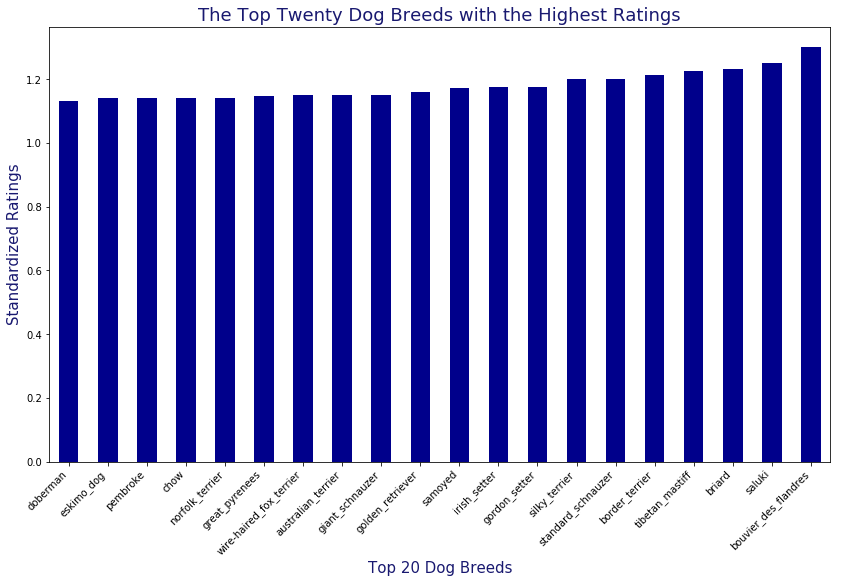

In [110]:
#plot bar graph
plt.subplots(figsize=(14, 8))
df.tail(20).plot(kind='bar',color='darkblue',width=0.5);
#rotate x-axis label
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right') #Source: https://benalexkeen.com/bar-charts-in-matplotlib/
#set chart titles and labels
plt.title('The Top Twenty Dog Breeds with the Highest Ratings',fontsize=18,color='#191970')
plt.xlabel('Top 20 Dog Breeds',fontsize=15,color='#191970')
plt.ylabel('Standardized Ratings',fontsize=15,color='#191970');

### Insights 2: Dog Breeds with highest favourite counts

In [111]:
#find the top 10 breeds with highest likes(aggregated values)
df1=twitter_data_enhanced.groupby('dog_breed').favorite_count.sum().sort_values()
df1.tail(10)

dog_breed
malamute               326218
pug                    348894
cocker_spaniel         377866
chow                   417015
samoyed                514963
french_bulldog         561574
chihuahua              718375
pembroke               967625
labrador_retriever    1127104
golden_retriever      1801807
Name: favorite_count, dtype: int64

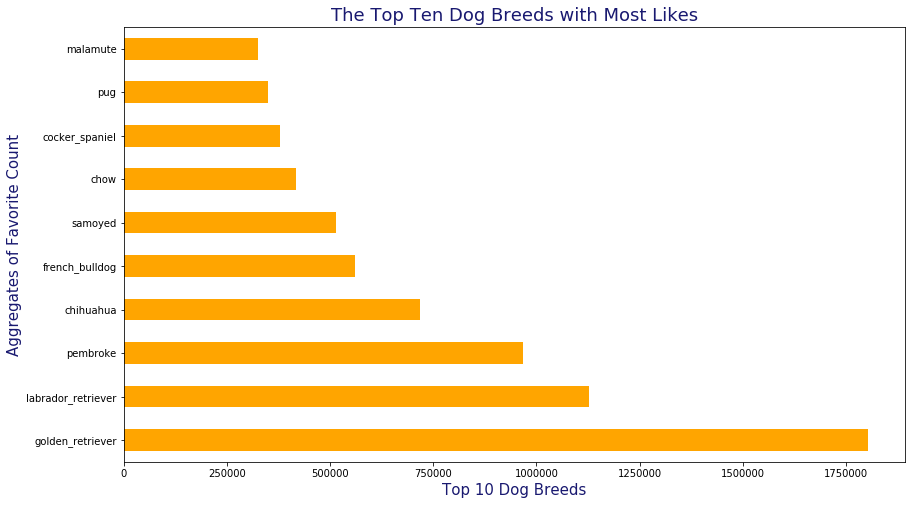

In [112]:
plt.subplots(figsize=(14, 8))
df1.tail(10).plot(kind='barh',color='orange',width=0.5);
#invert y-axis label
plt.gca().invert_yaxis()
#set chart titles and labels
plt.title('The Top Ten Dog Breeds with Most Likes',fontsize=18,color='#191970')
plt.xlabel('Top 10 Dog Breeds',fontsize=15,color='#191970')
plt.ylabel('Aggregates of Favorite Count',fontsize=15,color='#191970');

### Insight 3: Which dog stages have higher retweet counts

In [113]:
#check the value count for each dog stage
twitter_data_enhanced.dog_stage.value_counts()

pupper         205
doggo           64
puppo           23
floofer          7
doggopupper      5
Name: dog_stage, dtype: int64

In [114]:
#find the average retweet_count for each dog stage
twitter_data_enhanced.groupby('dog_stage').retweet_count.mean().sort_values()

dog_stage
pupper         2090.317073
floofer        4344.285714
doggopupper    5076.200000
puppo          6310.608696
doggo          6378.968750
Name: retweet_count, dtype: float64

In [115]:
#find the sum of retweet_count for each dog stage
twitter_data_enhanced.groupby('dog_stage').retweet_count.sum().sort_values()

dog_stage
doggopupper     25381
floofer         30410
puppo          145144
doggo          408254
pupper         428515
Name: retweet_count, dtype: int64

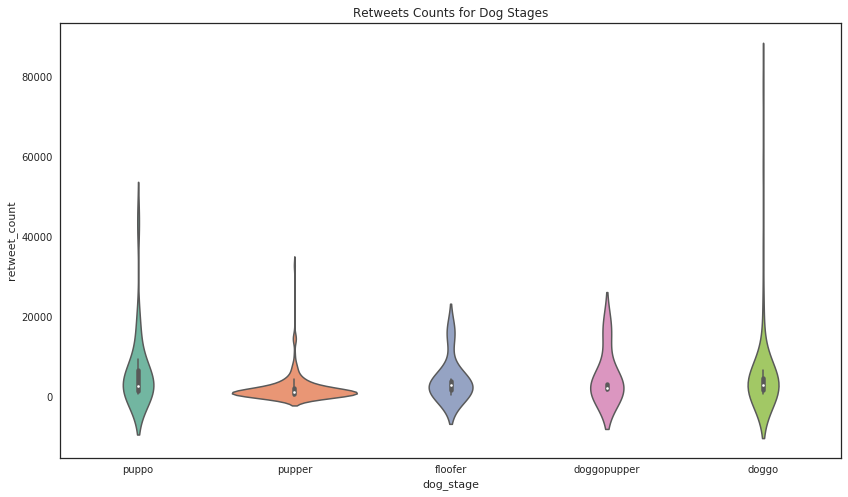

In [116]:
#plot violinplot to see the relation between dog stage and retweet count
# reference: https://www.geeksforgeeks.org/seaborn-categorical-plots/?ref=rp
#https://chartio.com/learn/charts/violin-plot-complete-guide/
plt.figure(figsize = (14, 8))
sns.set(style="white")
plt.title('Retweets Counts for Dog Stages')
ax=sns.violinplot(data=twitter_data_enhanced, x='dog_stage', y='retweet_count',linewidth=1.5,palette="Set2");


> In our analysis we can see that the value count for pupper is highest but the average retweet_count is for doggo. From our violinplot visualization we can see that the pupper has highest density around 0 and hence has the lowest average retweet count. Doggo stage has the maximum outliers, this means that some of the tweets have very high value of retweets. Hence we can say that doggo is the more popular dog stage as the shape of the graph shows that the frequency for retweet_count is spread over a large range of values. 

### Insight 4: Relationship between retweet_count and favorite_count

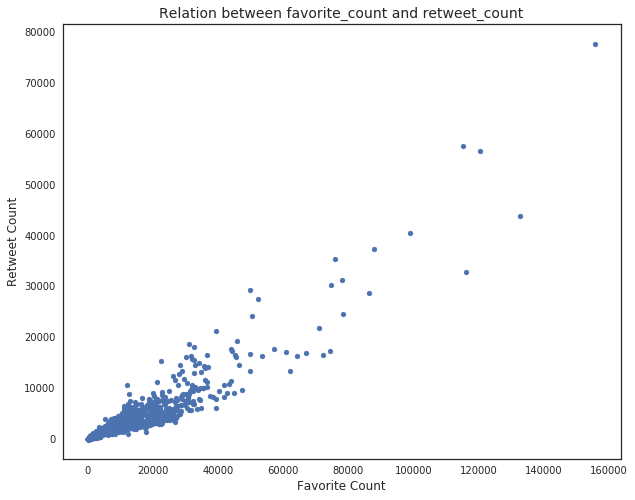

In [117]:
# scatterplot showing relation between retweet_count and favorite_count
twitter_data_enhanced.plot(x='favorite_count',y='retweet_count',kind='scatter',s=25, figsize=(10,8));
plt.title('Relation between favorite_count and retweet_count',fontsize=14);
plt.ylabel('Retweet Count',fontsize=12);
plt.xlabel('Favorite Count',fontsize=12);

> The scatterplot reflects a positive correlation between retweet count and favorite count. There is a clear indication that if a tweet is getting more likes then the probability of more retweets increases

### Insight 5: Relationship between retweet count, favorite count and ratings( standardized )

In [118]:
#find the index of rows which have outliers for rating_standardized column
twitter_data_enhanced.query('rating_standardized > 40').index

Int64Index([975, 1593], dtype='int64')

In [119]:
#drop rows with outliers as it will lead to incorrect analysis of the relationship between variables
df2=twitter_data_enhanced.drop([975,1593],axis=0)

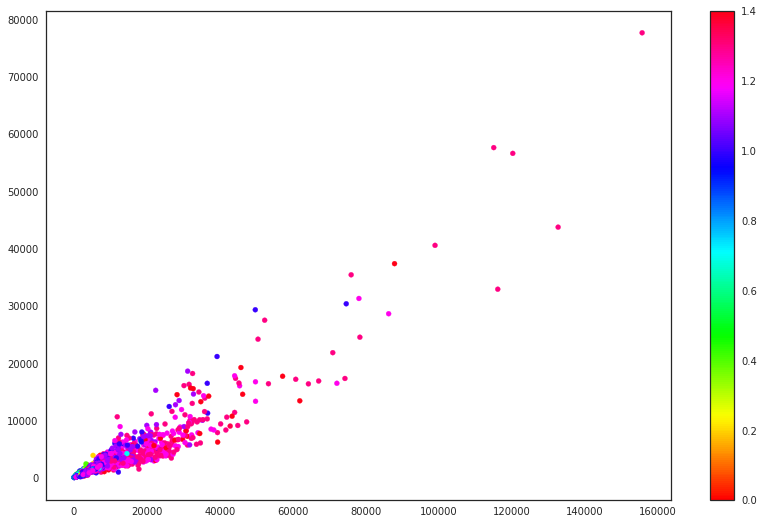

In [120]:
#plot the relation between standardized rating, retweet count and favorite count using scatter plot
# reference: https://stackoverflow.com/questions/55271471/plotting-some-third-variable-against-x-and-y-in-matplotlib-scatter
plt.figure(figsize = (14, 9))
x = df2.favorite_count
y = df2.retweet_count
z = df2.rating_standardized
plt.scatter(x,y, c=z, s=25, cmap=cm.hsv)
cbar= plt.colorbar()
plt.show()

> In the scatter plot above we can see the positive correlation between retweet count and favorite count. We also observe that higher retweet counts and favorite counts have higher ratings as the dots are mostly pink with specs of blue and red in areas under higher retweet count and favorite count.

### Insight 6: Which tweet has the highest rating, highest retweet count and highest favorite count

In [121]:
#find the tweets which have highest standardized ratings
#I have used the dataset which doesnot have outliers
df2[df2.rating_standardized == df2.rating_standardized.max()] 

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
3,825535076884762624,2017-01-29 02:44:34,Twitter for iPhone,Here's a very loving and accepting puppo. Appears to have read her Constitution well. 14/10 would pat head approvingly https://t.co/6ao80wIpV1,https://twitter.com/dog_rates/status/825535076884762624/photo/1,NaN,puppo,https://pbs.twimg.com/media/C3TjvitXAAAI-QH.jpg,1,rottweiler,0.681495,17681,57224,14.0,10.0,1.4
33,794205286408003585,2016-11-03 15:51:10,Twitter for iPhone,This is Laika. She was a space pupper. The first space pupper actually. Orbited earth like a h*ckin boss. 14/10 hero af https://t.co/trSjgY3h4g,"https://twitter.com/dog_rates/status/794205286408003585/photo/1,https://twitter.com/dog_rates/status/794205286408003585/photo/1,https://twitter.com/dog_rates/status/794205286408003585/photo/1",Laika,pupper,https://pbs.twimg.com/media/CwWVe_3WEAAHAvx.jpg,3,NaN,NaN,3390,9384,14.0,10.0,1.4
47,685547936038666240,2016-01-08 19:45:39,Twitter for iPhone,Everybody needs to read this. Jack is our first 14/10. Truly heroic pupper https://t.co/3m6bNGXWnM,"https://twitter.com/dog_rates/status/685547936038666240/photo/1,https://twitter.com/dog_rates/status/685547936038666240/photo/1",NaN,pupper,https://pbs.twimg.com/media/CYOONfZW8AA7IOA.jpg,1,NaN,NaN,15523,32732,14.0,10.0,1.4
53,854120357044912130,2017-04-17 23:52:16,Twitter for iPhone,Sometimes you guys remind me just how impactful a pupper can be. Cooper will be remembered as a good boy by so many. 14/10 rest easy friend https://t.co/oBL7LEJEzR,"https://twitter.com/dog_rates/status/854120357044912130/photo/1,https://twitter.com/dog_rates/status/854120357044912130/photo/1,https://twitter.com/dog_rates/status/854120357044912130/photo/1,http...",NaN,pupper,https://pbs.twimg.com/media/C9px7jyVwAAnmwN.jpg,4,black-and-tan_coonhound,0.854861,7207,31146,14.0,10.0,1.4
58,822462944365645825,2017-01-20 15:17:01,Twitter for iPhone,"This is Gabe. He was the unequivocal embodiment of a dream meme, but also one h*ck of a pupper. You will be missed by so many. 14/10 RIP https://t.co/M3hZGadUuO","https://twitter.com/dog_rates/status/822462944365645825/photo/1,https://twitter.com/dog_rates/status/822462944365645825/photo/1,https://twitter.com/dog_rates/status/822462944365645825/photo/1,http...",Gabe,pupper,https://pbs.twimg.com/media/C2n5rUUXEAIXAtv.jpg,3,pomeranian,0.960199,14475,28307,14.0,10.0,1.4
63,807621403335917568,2016-12-10 16:22:02,Twitter for iPhone,This is Ollie Vue. He was a 3 legged pupper on a mission to overcome everything. This is very hard to write. 14/10 we will miss you Ollie https://t.co/qTRY2qX9y4,"https://twitter.com/dog_rates/status/807621403335917568/photo/1,https://twitter.com/dog_rates/status/807621403335917568/photo/1,https://twitter.com/dog_rates/status/807621403335917568/photo/1,http...",Ollie,pupper,https://pbs.twimg.com/media/CzU_YVGUUAA3Xsd.jpg,3,golden_retriever,0.873233,3695,14834,14.0,10.0,1.4
83,742465774154047488,2016-06-13 21:16:49,Twitter for iPhone,"Was just informed about this hero pupper and others like her. Another 14/10, would be an absolute honor to pet https://t.co/hBTzPmj36Z","https://twitter.com/dog_rates/status/742465774154047488/photo/1,https://twitter.com/dog_rates/status/742465774154047488/photo/1",NaN,pupper,https://pbs.twimg.com/media/Ck3EribXEAAPhZn.jpg,1,NaN,NaN,3893,7226,14.0,10.0,1.4
156,881536004380872706,2017-07-02 15:32:16,Twitter for iPhone,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,https://twitter.com/dog_rates/status/881536004380872706/video/1,NaN,pupper,https://pbs.twimg.com/ext_tw_video_thumb/881535971568889856/pu/img/9bawiZ--8FKywTkz.jpg,1,samoyed,0.281463,14538,46275,14.0,10.0,1.4
244,828381636999917570,2017-02-05 23:15:47,Twitter for iPhone,Meet Doobert. He's a

In [122]:
#list the tweet_ids which have the maximum ratings
list(df2[df2.rating_standardized == df2.rating_standardized.max()]['tweet_id'])

['825535076884762624',
 '794205286408003585',
 '685547936038666240',
 '854120357044912130',
 '822462944365645825',
 '807621403335917568',
 '742465774154047488',
 '881536004380872706',
 '828381636999917570',
 '819006400881917954',
 '819004803107983360',
 '821407182352777218',
 '755206590534418437',
 '890240255349198849',
 '832273440279240704',
 '820314633777061888',
 '813812741911748608',
 '828650029636317184',
 '860184849394610176',
 '863079547188785154',
 '864873206498414592',
 '856282028240666624',
 '856526610513747968',
 '878057613040115712',
 '870063196459192321',
 '868880397819494401',
 '831911600680497154',
 '851464819735769094',
 '852226086759018497',
 '841439858740625411',
 '740373189193256964',
 '778408200802557953',
 '774314403806253056',
 '762035686371364864',
 '884441805382717440',
 '887517139158093824']

In [123]:
#find the tweet which has the maximum retweet count
twitter_data_enhanced[twitter_data_enhanced.retweet_count == twitter_data_enhanced.retweet_count.max()] 

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
293,744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,labrador_retriever,0.825333,77591,155722,13.0,10.0,1.3


In [124]:
#find th tweet which has the maximum favorite count
twitter_data_enhanced[twitter_data_enhanced.favorite_count == twitter_data_enhanced.favorite_count.max()] 

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,jpg_url,img_num,dog_breed,img_prediction_conf,retweet_count,favorite_count,rating_numerator_new,rating_denominator_new,rating_standardized
293,744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,labrador_retriever,0.825333,77591,155722,13.0,10.0,1.3


In [125]:
#find the tweet_id for the tweet which has maximum retweet count and favorite count 
twitter_data_enhanced[twitter_data_enhanced.favorite_count == twitter_data_enhanced.favorite_count.max()]['tweet_id']

293    744234799360020481
Name: tweet_id, dtype: object

> We can once again see that there is a positive correlation between retweet count and favorite count as the tweet with the highest retweet and highest likes are the same.